# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:
1. [Read SPX Options Data](#read)
2. [Plot the Volatility Skew](#plot)
3. [Compute the Skew](#skew)
3. [Conclusion](#conclusion)

## Import Libraries

In [59]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from utility import remove_illiquid_options, reshape_options_long_to_wide, reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
file = "data/intermediate/spx_options_2023_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.35367,0.00,0.00,0.0,0.0,2845.7,2854.60,0.0,0.05
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.17498,2623.64,0.10,1.0,10.0,2643.4,2651.80,0.0,0.05
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.00000,-0.00031,NaN,1.02388,2377.30,0.07,1.0,2.0,2444.1,2453.70,0.0,0.05
2023-01-04,1500.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,0.95679,0.00,0.10,0.0,1.0,2347.4,2355.90,0.0,0.05
2023-01-04,1600.0,3853.39,27.0,2023-01-31,1.00000,-0.00029,NaN,0.89294,2183.32,0.05,2.0,2.0,2244.6,2253.10,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,5800.0,4772.17,0.0,2023-12-29,0.00084,-0.92248,1.27964,2.46351,0.05,1186.49,5.0,44.0,0.0,0.05,1028.3,1029.90
2023-12-29,5900.0,4772.17,0.0,2023-12-29,0.00027,-0.91952,1.38397,2.68042,0.07,1108.69,3.0,123.0,0.0,0.05,1128.0,1129.30
2023-12-29,6000.0,4772.17,0.0,2023-12-29,0.00026,-0.91572,1.48449,2.91246,0.05,0.00,6.0,0.0,0.0,0.05,1228.0,1229.20


<Axes: xlabel='date'>

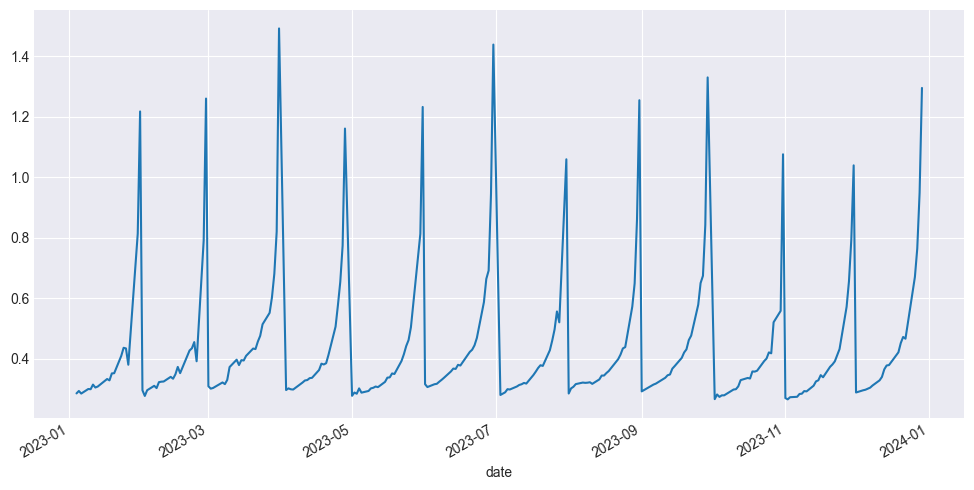

In [62]:
options.groupby("date")["p_iv"].mean().plot(figsize=(12, 6))

<Axes: xlabel='date'>

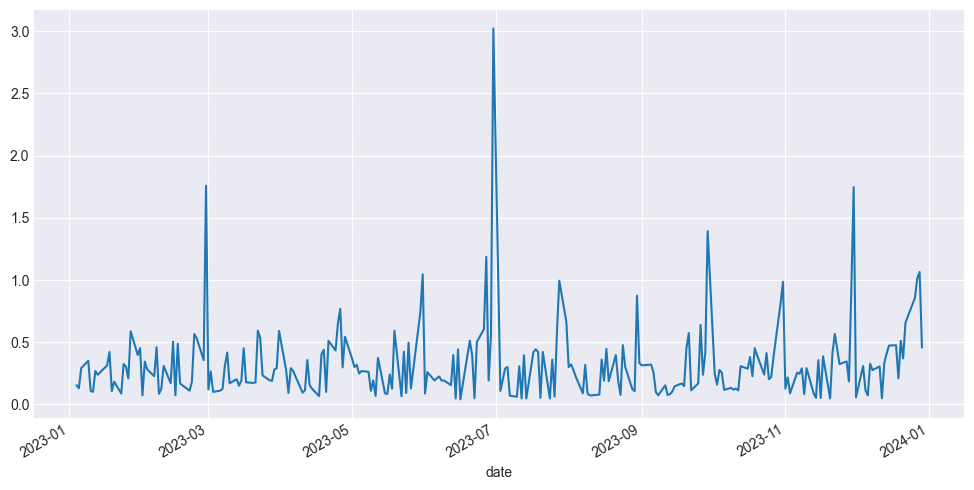

In [61]:
options.groupby("date")["c_iv"].mean().plot(figsize=(12, 6))

## Plot the Skew

In [83]:
dates = ["2023-01-30", "2023-02-01", "2023-03-15"]

In [84]:
def compute_iv_smile(options, date):
    options_red = options.loc[options.index == date].copy()

    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= 1000)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [85]:
iv_smiles = {}
for date in dates:
    iv_smile = compute_iv_smile(options, date)
    iv_smiles[date] = iv_smile

In [86]:
def plot_iv_smiles(iv_smiles, ticker):
    """
    Plots implied volatility smiles over different dates.

    Parameters:
        iv_smiles (dict): keys = dates, values = pandas Series with strikes as index and IVs as values
        ticker (str): name of the underlying (for title)
    """
    plt.figure(figsize=(12, 6))

    for date, iv_smile in iv_smiles.items():
        # Ensure date label is string
        if isinstance(date, str):
            label = date
        else:
            label = pd.to_datetime(date).strftime('%Y-%m-%d')

        # Only plot if iv_smile is not empty
        if iv_smile is not None and not iv_smile.empty:
            plt.scatter(iv_smile.index, iv_smile.values, marker='o', label=label)

    plt.xlabel('Strike', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Implied Volatility Smiles for {ticker} Options', fontsize=16)
    plt.legend(title="Date", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

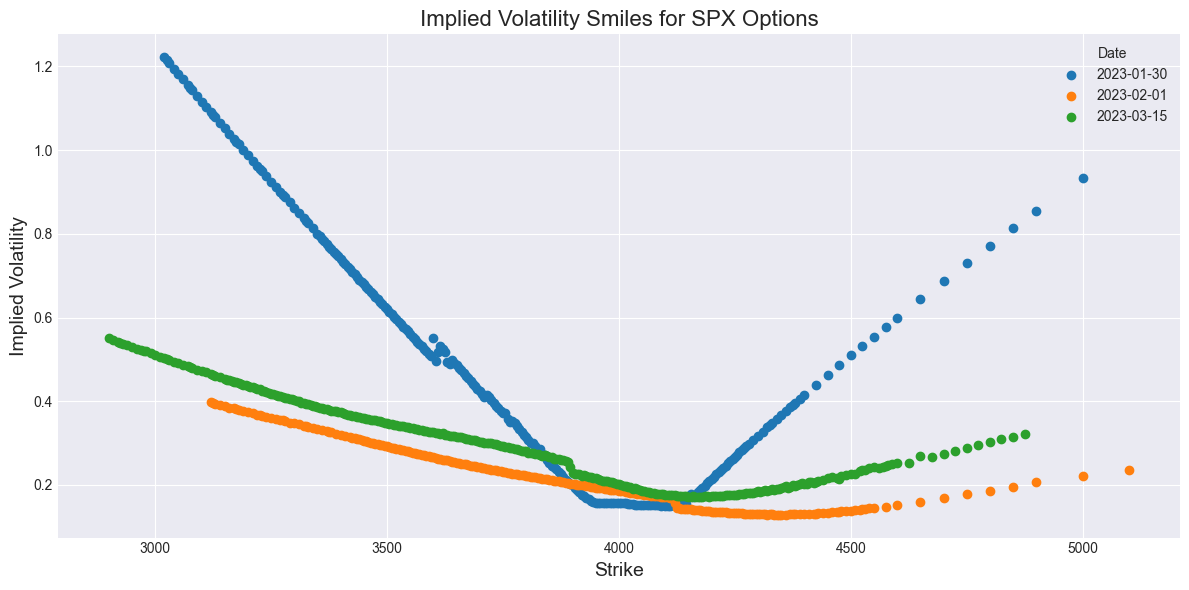

In [87]:
plot_iv_smiles(iv_smiles, "SPX")

As we can see the shape of the smile can change drastically over time, and skyrocket close to expiry. As DTE increas teh skew becomes flatter.

We can also notice the few transactions for deep OTM Call compared to Puts, which is explained by the investors' demand for tail protection against downside moves.

## Remove illiquid options

In order to obtain more reliable backtest results, we are going to remove illiquid options as trading them would lead to high slippage, bid-ask spread which can maek our edge vanish. 

In [49]:
options = reshape_options_wide_to_long(options)
options.head()

,strike,underlying_last,dte,expiry,delta,iv,last,volume,bid,ask,option_type
date,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.0,NaN,0.00,0.0,2845.7,2854.60,C
2023-01-04,1000.0,3853.39,27.0,2023-01-31,0.0,1.35367,0.00,0.0,0.0,0.05,P
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.0,NaN,2623.64,1.0,2643.4,2651.80,C
2023-01-04,1200.0,3853.39,27.0,2023-01-31,0.0,1.17498,0.10,10.0,0.0,0.05,P
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.0,NaN,2377.30,1.0,2444.1,2453.70,C


### Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

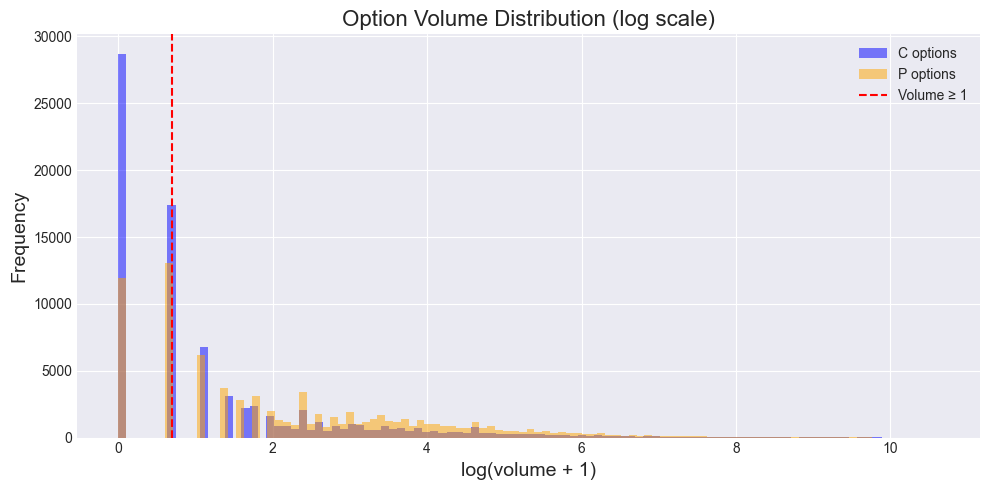

In [9]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)

plt.figure(figsize=(10, 5))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_volumes = (subset["volume"] + 1).apply(np.log)
    log_volumes.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(2), color='r', linestyle='--', label='Volume ≥ 1')
plt.title("Option Volume Distribution (log scale)", fontsize=16)
plt.xlabel("log(volume + 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

### Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [52]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (options["ask"] - options["bid"]) / options["mid"]

options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2023-01-04,2643.4,2651.8,2647.60,0.003173
2023-01-04,2444.1,2453.7,2448.90,0.003920
2023-01-04,2244.6,2253.1,2248.85,0.003780
2023-01-04,2048.4,2056.9,2052.65,0.004141
2023-01-04,1849.1,1857.5,1853.30,0.004532
...,...,...,...,...
2023-12-29,828.0,829.3,828.65,0.001569
2023-12-29,928.0,929.2,928.60,0.001292
2023-12-29,1028.3,1029.9,1029.10,0.001555


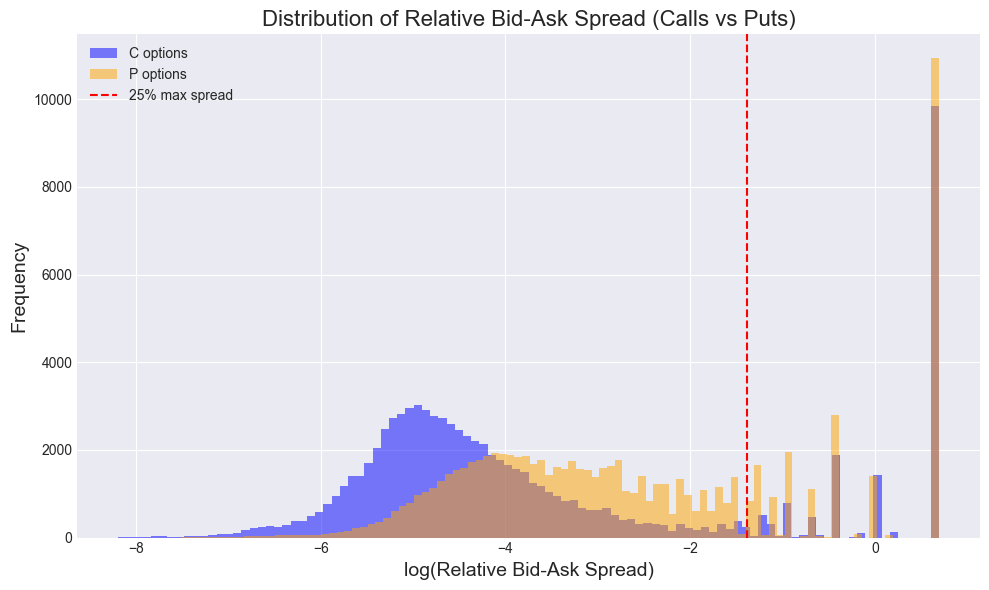

In [12]:
plt.figure(figsize=(10, 6))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_rel_spread = (subset["rel_spread"] + 1e-6).apply(np.log)
    log_rel_spread.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(0.25), color='red', linestyle='--', label="25% max spread")
plt.xlabel("log(Relative Bid-Ask Spread)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Relative Bid-Ask Spread (Calls vs Puts)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

### Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

In [53]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_94192/1300706182.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  options.groupby(["option_type", "moneyness_bin"])["volume"]


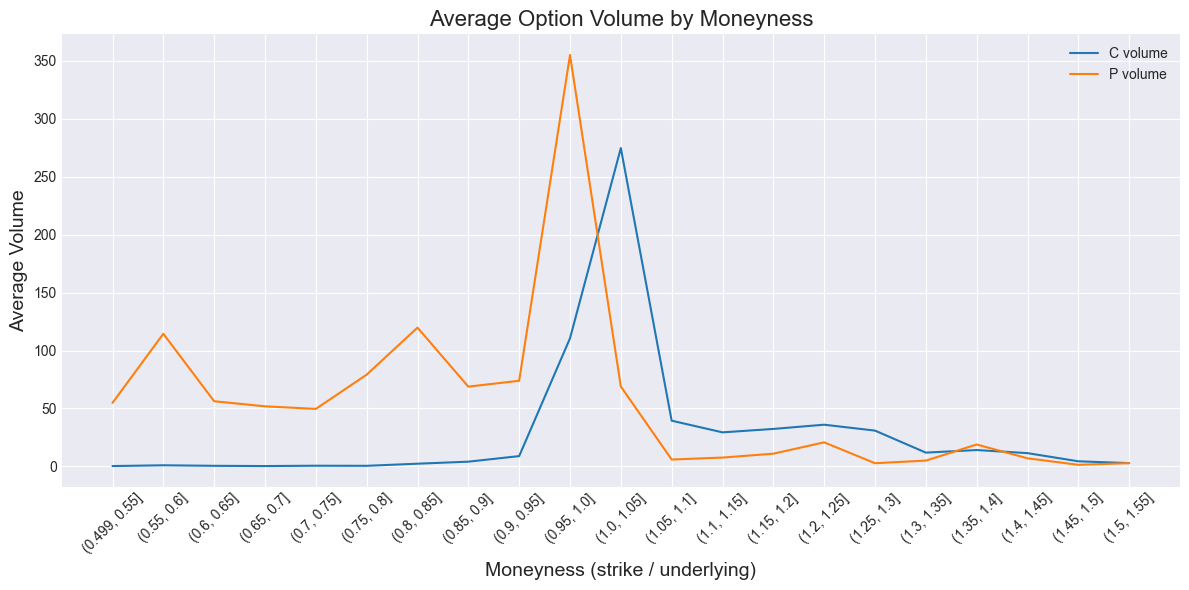

In [14]:
plt.figure(figsize=(12, 6))

for option_type in OPTION_TYPES:
    subset = avg_vol[avg_vol["option_type"] == option_type]
    plt.plot(
        subset["moneyness_bin"].astype(str),
        subset["volume"],
        label=f"{option_type} volume"
    )

plt.xticks(rotation=45)
plt.xlabel("Moneyness (strike / underlying)", fontsize=14)
plt.ylabel("Average Volume", fontsize=14)
plt.title("Average Option Volume by Moneyness", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [15]:
n = len(options)

# Volume filter
options = options[options["volume"] >= 1].copy()

# Bid-Ask filter
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()
options = options[options["rel_spread"] <= 0.25].copy()

# Moneyness filter
options = options[(options["moneyness"] >= 0.8) & (options["moneyness"] <= 1.2)]

pct_dropped = 100 * (1 - len(options) / n)
print(f"Percentage of observations dropped across all filters: {pct_dropped:.2f}%")

Percentage of observations dropped across all filters: 49.05%


## Compute the skew

As systematic traders, a measure of this skew is necessary to quantitify this difference of Iv across strikes. The skew can be measured as the difference between OTM Puts and Calls, often normalized by the ATM IV for comapriosn across time and underlyings:

$$
Skew = \frac{IV_{OTM-Put} - IV_{OTM-Call}}{IV_{ATM}}
$$


The 2 methods we are goign to explore differ in how they choose the strike for teh OTM Call and Put

### Skew as a Fixed % of the At-The-Money (ATM) Strike

This measure is prefered over choosing a specific strike value, as we can apply this technique systematically across time and underlying. This method consists in choosing the strike by a % distance of the ATM strike, typically **10-15%** above and below the ATM strike.

To improve the rading realism, we choose the highest liquid options usign the `volume` column from a lower and upper bound % of the ATM Strike.

In [16]:
# TODO: Need to make sure that when when extratcing the STrike with max volume we choose 

def get_highest_volume_strike(group, lower_bound, upper_bound, min_volume=1):
    underlying = group["underlying_last"].iloc[0]
    low = underlying * lower_bound
    high = underlying * upper_bound

    filtered = group[
        (group["strike"] >= low) &
        (group["strike"] <= high) &
        (group["volume"] >= min_volume) # Can add other filter like bid-ask spread
    ]

    if filtered.empty:
        return np.nan

    return filtered.iloc[filtered["volume"].argmax(), filtered.columns.get_loc("strike")]

In [17]:
lower_strike_atm = 0.99
upper_strike_atm = 1.01

atm_by_date = options.groupby("date").apply(lambda x: get_highest_volume_strike(x, lower_strike_atm, upper_strike_atm)).rename("atm_strike")
options = options.merge(atm_by_date, on="date")

We intentionally choose a **larger percentage for the Put** side because OTM puts tend to be more liquid than OTM calls, especially in equity and index options where downside protection is in higher demand.

In [18]:
lower_strike_otm_put = 0.87
upper_strike_otm_put = 0.90

lower_strike_otm_call = 1.05
upper_strike_otm_call = 1.08

otm_put_by_date = (
    options
    .groupby("date")
    .apply(lambda x: get_highest_volume_strike(x, lower_strike_otm_put, upper_strike_otm_put))
    .rename("otm_put_strike")
)
otm_call_by_date = (
    options
    .groupby("date")
    .apply(lambda x: get_highest_volume_strike(x, lower_strike_otm_call, upper_strike_otm_call))
    .rename("otm_call_strike")
)

options = options.merge(otm_put_by_date, on="date")
options = options.merge(otm_call_by_date, on="date")

In [19]:
"""
def get_otm_strike(group, otm_pct_target, round_to=25, volume_threshold=1):

    Find the nearest strike to a target % of the underlying,
    rounded to the nearest `round_to` level and filtered by minimum volume.
    
    Parameters:
        group (pd.DataFrame): group of options for a single date
        otm_pct_target (float): e.g. 0.85 for 15% OTM put, 1.10 for 10% OTM call
        round_to (int): nearest strike increment to match (e.g. 25 or 50)
        volume_threshold (int): minimum volume to consider a strike liquid
        
    Returns:
        float: selected strike
    underlying = group["underlying_last"].iloc[0]
    target_strike = underlying * otm_pct_target

    # Filter strikes to those that are multiples of `round_to` and have enough volume
    filtered = group[
        (group["strike"] % round_to == 0) &
        (group["volume"] >= volume_threshold)
    ]

    if filtered.empty:
        return np.nan  # or optionally: fallback to closest regardless of volume/rounding

    # Find strike closest to target
    closest_idx = (filtered["strike"] - target_strike).abs().idxmin()
    return filtered.loc[closest_idx, "strike"]


otm_put_strike_pct = 0.88
otm_call_strike_pct = 1.07

otm_put_by_date = (
    options
    .groupby("date")
    .apply(lambda x: get_nearest_liquid_strike(x, 0.85, 0.95))
    .rename("otm_put_strike")
)
otm_call_by_date = (
    options
    .groupby("date")
    .apply(lambda x: get_nearest_liquid_strike(x, 1.05, 1.15))
    .rename("otm_call_strike")
)

options = options.merge(otm_put_by_date, on="date")
options = options.merge(otm_call_by_date, on="date")
"""

'\ndef get_otm_strike(group, otm_pct_target, round_to=25, volume_threshold=1):\n\n    Find the nearest strike to a target % of the underlying,\n    rounded to the nearest `round_to` level and filtered by minimum volume.\n\n    Parameters:\n        group (pd.DataFrame): group of options for a single date\n        otm_pct_target (float): e.g. 0.85 for 15% OTM put, 1.10 for 10% OTM call\n        round_to (int): nearest strike increment to match (e.g. 25 or 50)\n        volume_threshold (int): minimum volume to consider a strike liquid\n\n    Returns:\n        float: selected strike\n    underlying = group["underlying_last"].iloc[0]\n    target_strike = underlying * otm_pct_target\n\n    # Filter strikes to those that are multiples of `round_to` and have enough volume\n    filtered = group[\n        (group["strike"] % round_to == 0) &\n        (group["volume"] >= volume_threshold)\n    ]\n\n    if filtered.empty:\n        return np.nan  # or optionally: fallback to closest regardless of vo

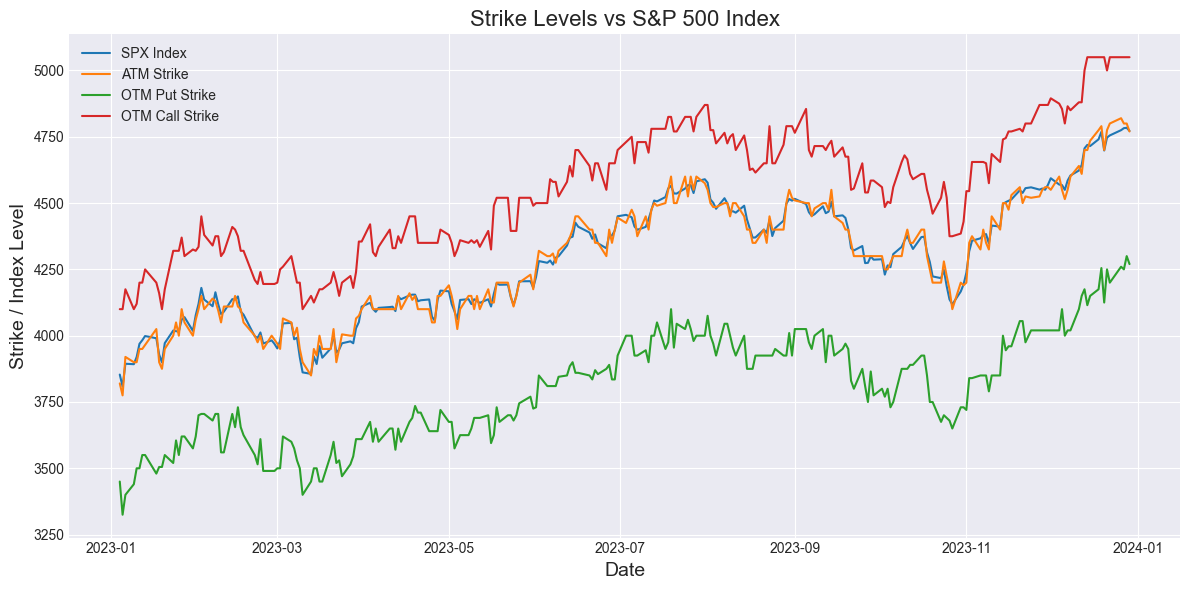

In [20]:
grouped = options.groupby("date").agg({
    "underlying_last": "first",
    "atm_strike": "first",
    "otm_put_strike": "first",
    "otm_call_strike": "first"
})

plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped["underlying_last"], label="SPX Index")
plt.plot(grouped.index, grouped["atm_strike"], label="ATM Strike")
plt.plot(grouped.index, grouped["otm_put_strike"], label=f"OTM Put Strike")
plt.plot(grouped.index, grouped["otm_call_strike"], label=f"OTM Call Strike")

plt.title("Strike Levels vs S&P 500 Index", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Strike / Index Level", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Those strike values ensure that we can execute the strategy on the most liquid options around the corresponding % of the ATM Strike, and we will be usign them to long/short the skew.

In [ ]:
def get_iv(group, lower_bound, upper_bound):
    atm_strike = group["atm_strike"].iloc[0]

    calls = group[
        (group.option_type == "C") &
        (group.strike >= upper_bound * atm_strike)
    ]
    puts  = group[
        (group.option_type == "P") &
        (group.strike <= lower_bound * atm_strike)
    ]

    # volume-weighted IV
    otm_call_iv = np.average(calls.iv, weights=calls.volume) if len(calls) else np.nan
    otm_put_iv  = np.average(puts.iv,  weights=puts.volume)  if len(puts)  else np.nan

    # exact ATM IV
    atm_row = group.loc[group.strike == atm_strike, "iv"]
    atm_iv   = atm_row.iloc[0] if len(atm_row) else np.nan

    return pd.Series({
        "atm_iv":      atm_iv,
        "otm_put_iv":  otm_put_iv,
        "otm_call_iv": otm_call_iv
    })

iv_df = options.groupby("date").apply(lambda x: get_iv(x, 0.9, 1.05)).reset_index()

options = options.merge(iv_df, on="date")

In [37]:
def fill_missing_ivs(row):
    ivs = [row["atm_iv"], row["otm_put_iv"], row["otm_call_iv"]]
    available = [iv for iv in ivs if pd.notna(iv)]
    
    # If at least one IV is available, use its value to fill missing ones
    if available:
        fallback = np.mean(available)  # or just use available[0] if you prefer
        row["atm_iv"] = row["atm_iv"] if pd.notna(row["atm_iv"]) else fallback
        row["otm_put_iv"] = row["otm_put_iv"] if pd.notna(row["otm_put_iv"]) else fallback
        row["otm_call_iv"] = row["otm_call_iv"] if pd.notna(row["otm_call_iv"]) else fallback
    return row

iv_df_filled = iv_df.apply(fill_missing_ivs, axis=1)

<Axes: >

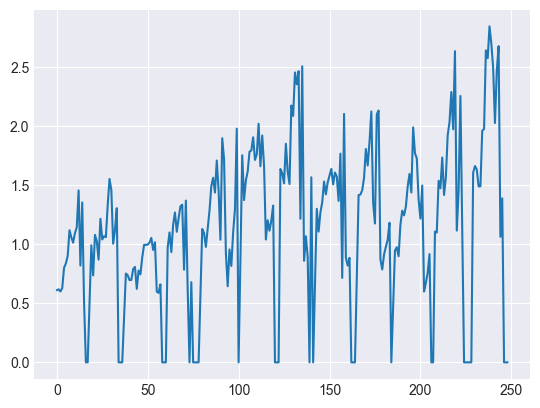

In [ ]:
iv_df_filled.iv_skew.plot()

In [99]:
iv_df_filled["iv_skew"] = ((iv_df_filled.otm_put_iv - iv_df_filled.otm_call_iv) / iv_df_filled.atm_iv)

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_94192/1186037555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv_df_filled["iv_skew"] = ((iv_df_filled.otm_put_iv - iv_df_filled.otm_call_iv) / iv_df_filled.atm_iv)


### 25-Delta Skew

In [25]:

# TODO: COmpue the skew usign standard method and comapre with delta skew

# TODO: Inteoduce the backetsting logic, teh filters we will be using, and see teh diff between the 2

# TODO: Use advanced signals like BB, time the entry/exit based on a forecasting model

# TODO: Present advanced strategies like Implied Skew vs RV Skew, Skew disperisoon

## Construct the strategy

In [26]:
spy = yf.download("SPY", start=options.index[0], end=options.index[-1])["Close"]
spy

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_94192/2389249413.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=options.index[0], end=options.index[-1])["Close"]
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFPricesMissingError('possibly delisted; no price data found  (1d 0 -> 86593) (Yahoo error = "Data doesn\'t exist for startDate = 0, endDate = 86593")')


Ticker,SPY
Date,


In [27]:
data = pd.merge(options, spy["Close"], left_index=True, right_index=True)
data

KeyError: 'Close'

In [ ]:
spx_spy_corr = data[["SPX", "SPY"]].corr().iloc[0, 1]
print("Correlation between SPX Index and SPY ETF:", spx_spy_corr)

#data.drop("SPX", axis=1, inplace=True)

Correlation between SPX Index and SPY ETF: 0.9992109585255068


Here we can use the SPY ETF as a proxy for the SPX inde which is not tradeable.